In [1]:
import gensim.downloader as api

word2VecModel = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


In [2]:
import os
filePath = "simplePuzzles.json"

# If the json file is already fetched from our GCS, do not re-fetch.
if not os.path.exists(filePath):
  # You can upload the file to https://console.cloud.google.com/storage/browser/cs221team
  # Accessible @ https://storage.googleapis.com/cs221team/simplePuzzles.json
  !gsutil cp gs://cs221team/simplePuzzles.json simplePuzzles.json


Copying gs://cs221team/simplePuzzles.json...
/ [1 files][ 88.9 KiB/ 88.9 KiB]                                                
Operation completed over 1 objects/88.9 KiB.                                     


In [10]:
import json
import numpy as np
from sklearn.model_selection import train_test_split

def word_to_vec(word, model):
  """
  for a given word and word2vec model, return a vector representation. If the word is not found
  in the model, return an empty ndarray of dimension (model.vector_size,)
  """
  return np.array(model[word.lower()]) if word.lower() in model else None

def average_multi_word_to_vec(str, model):
  vecs = [np.array(model[c]) for c in str.lower().split() if c in model]
  return np.array(np.mean(vecs, axis=0)) if len(vecs) != 0 else None

def load_samples(filePath, model):
  """
  load from the json game data and output train/test split. Each input is mapped to
  a category. An input and category could contain multiple words and this function
  averages the vector embedded values. The training set is an ndarray of size (num_samples, word2VecModel.vector_size)
  The label set is an ndarray of the same dimension. For example:
  x_train: [v1, v2, v3, v4, v5, v6, v7, v8]
  y_train: [c1, c1, c1, c1, c2, c2, c2, c2]
  where vn are different word vectors and cn are different category vectors. Since the game
  always have four words mapped to the same category, we will see duplicate categories in y_train.
  Note: if a word is not found in the word2vec model, it is ignored. If a category is not found in the
  model, all associated words for it is ignored.

  filePath: the path to game data in json format
  model: a word2vec model
  """

  with open(filePath) as f:
    data = json.load(f)
    samples = []
    sample_labels = []

    print(f"processing {len(data)} entries of game data")
    for i in range(len(data)):
      # Sample: {'id': 1, 'wordCategories': {'WET WEATHER': ['HAIL', 'RAIN', 'SLEET', 'SNOW'], 'NBA TEAMS': ['BUCKS', 'HEAT', 'JAZZ', 'NETS'], 'KEYBOARD KEYS': ['OPTION', 'RETURN', 'SHIFT', 'TAB'], 'PALINDROMES': ['KAYAK', 'LEVEL', 'MOM', 'RACECAR']}}

      for category, input in data[i]['wordCategories'].items():
        # if each category has multiple words, average the vector together. If all of the words
        # are not in word2vec, skip this sample.
        label = average_multi_word_to_vec(category, model)
        if label is None:
          continue

        for words in input:
          # it's possible the input can have multiple words. average them.
          average_input_vector = average_multi_word_to_vec(words, model)
          if average_input_vector is None:
            continue

          samples.append(average_input_vector)
          sample_labels.append(label)


    assert len(samples) == len(sample_labels)
    assert samples[0].shape == sample_labels[0].shape

  x_train, x_test, y_train, y_test = train_test_split(
    np.array(samples), np.array(sample_labels), test_size=0.05, random_state=0)
  print(f"num of train samples {len(x_train)}, num of test samples {len(x_test)}")
  print(f"x_train shape {x_train.shape} y_train shape {y_train.shape}")
  return x_train, y_train, x_test, y_test

In [4]:
import torch
import torch.nn as nn
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(25, 100)
        self.fc2 = nn.Linear(100, 75)
        self.fc3 = nn.Linear(75, 25)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [34]:
import torch.optim as optim
from tqdm import tqdm
import copy

def train_network(model, X_train, Y_train, X_test, Y_test):
  loss_fn = nn.MSELoss()  # mean square error
  optimizer = optim.SGD(model.parameters(), lr=0.01)

  n_epochs = 100   # number of epochs to run
  batch_size = 100  # size of each batch
  batch_start = torch.arange(0, len(X_train), batch_size)

  # Hold the best model
  best_mse = np.inf   # init to infinity
  best_weights = None
  history = []
  model.float()
  for epoch in range(n_epochs):
      model.train()
      with tqdm(batch_start, unit="batch", mininterval=0, position=0, leave=True) as bar:
          bar.set_description(f"Epoch {epoch}")
          for start in bar:
              X_batch = X_train[start:start+batch_size]
              Y_batch = Y_train[start:start+batch_size]

              Y_pred = model(X_batch)
              loss = loss_fn(Y_pred, Y_batch)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              # print progress
              bar.set_postfix(mse=float(loss))

      # evaluate accuracy at end of each epoch
      model.eval()
      Y_pred = model(X_test)
      mse = loss_fn(Y_pred, Y_test)
      mse = float(mse)
      history.append(mse)
      if mse < best_mse:
          best_mse = mse
          best_weights = copy.deepcopy(model.state_dict())

  return history, best_mse, best_weights

In [35]:
X_train, Y_train, X_test, Y_test = load_samples(filePath, word2VecModel)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
Y_test = torch.tensor(Y_test, dtype=torch.float32, device=device)

neural_network = NeuralNetwork().to(device)
history, best_mse, best_weights = train_network(neural_network, X_train, Y_train, X_test, Y_test)

processing 342 entries of game data
num of train samples 4997, num of test samples 264
x_train shape (4997, 25) y_train shape (4997, 25)


Epoch 99: 100%|██████████| 50/50 [00:00<00:00, 203.03batch/s, mse=0.339]


MSE: 0.31
RMSE: 0.56


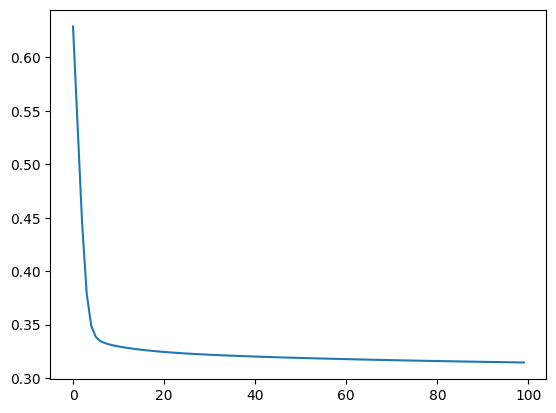

In [36]:
import matplotlib.pyplot as plt
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [37]:
def eval_model(filePath, neural_network, word2vecModel, best_weights):
  loss = nn.MSELoss()
  neural_network.load_state_dict(best_weights)
  positive = 0
  total_tests = 0

  with open(filePath) as f:
    data = json.load(f)

    neural_network.eval()
    with torch.no_grad():
      for i in range(len(data)):
        categories = list(data[i]['wordCategories'].keys())
        average_category_vecs = [average_multi_word_to_vec(cat, word2vecModel) for cat in categories]
        average_category_vecs = [torch.tensor(v, dtype=torch.float32, device=device) for v in average_category_vecs if v is not None]
        # if any category cannot be mapped to vec by word2vec, skip it
        if len(average_category_vecs) != 4:
          continue
        for cat in categories:
          words = data[i]['wordCategories'][cat]
          word_vecs = [average_multi_word_to_vec(word, word2vecModel) for word in words]
          word_vecs = [torch.tensor(v, dtype=torch.float32, device=device) for v in word_vecs if v is not None]
          for v in word_vecs:
            output = neural_network(v)
            loss_list = [float(loss(output, category_vec)) for category_vec in average_category_vecs]
            loss_and_category = zip(loss_list, categories)

            # sort by loss
            result = sorted(zip(loss_list, categories), key=lambda x: x[0])
            if result[0][1] == cat:
              positive += 1
            total_tests += 1
  print("words matching true category:", positive, "out of total:", total_tests, "accuracy:", positive / total_tests)

eval_model(filePath, neural_network, word2VecModel, best_weights)

words matching true category: 1305 out of total: 4786 accuracy: 0.27267028834099455
